<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/RF(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Random Forest Model for Agricultural Production Classification
# Step-by-step implementation with training, validation, and testing

# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support, log_loss)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [21]:


print("Step 1: Libraries imported successfully!")

# Step 2: Load the datasets
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print("Step 2: Datasets loaded successfully!")
    print(f"Training data shape: {train_df.shape}")
    print(f"Validation data shape: {validation_df.shape}")
    print(f"Test data shape: {test_df.shape}")

    # Display first few rows of training data
    print("\nFirst 5 rows of training data:")
    print(train_df.head())

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure train.csv, validation.csv, and test.csv are in the current directory")


Step 1: Libraries imported successfully!
Step 2: Datasets loaded successfully!
Training data shape: (3942, 84)
Validation data shape: (845, 84)
Test data shape: (845, 84)

First 5 rows of training data:
   Production (M.Ton)  Area (Acres)  Temperature at 2 Meters Range (C)  Year  \
0              2592.0        1039.0                              31.79  2015   
1              1392.0         312.0                              35.12  2019   
2                11.0           8.0                              35.46  2016   
3              3335.0        1036.0                              32.49  2017   
4               661.0         375.0                              28.09  2017   

   soil_temperature_0_to_7cm(C)  \
0                      25.30380   
1                      25.74725   
2                      26.28978   
3                      27.18630   
4                      26.08082   

   Root Zone Soil Wetness (surface to 100 cm below)  \
0                                              0.6

In [22]:

# Step 3: Data Preprocessing and Label Creation
def create_production_labels(df):
    """Create production labels based on quantiles"""
    # Calculate quantiles for production
    q33 = df['Production (M.Ton)'].quantile(0.33)
    q67 = df['Production (M.Ton)'].quantile(0.67)

    # Create labels
    def categorize_production(value):
        if value <= q33:
            return 'low'
        elif value <= q67:
            return 'medium'
        else:
            return 'high'

    df['production_label'] = df['Production (M.Ton)'].apply(categorize_production)
    return df, q33, q67

# Apply label creation to all datasets
train_df, q33_train, q67_train = create_production_labels(train_df)
validation_df['production_label'] = validation_df['Production (M.Ton)'].apply(
    lambda x: 'low' if x <= q33_train else ('medium' if x <= q67_train else 'high')
)
test_df['production_label'] = test_df['Production (M.Ton)'].apply(
    lambda x: 'low' if x <= q33_train else ('medium' if x <= q67_train else 'high')
)

print("Step 3: Production labels created successfully!")
print(f"Training data quantiles - Q33: {q33_train:.2f}, Q67: {q67_train:.2f}")
print("Label distribution in training data:")
print(train_df['production_label'].value_counts())


Step 3: Production labels created successfully!
Training data quantiles - Q33: 1071.56, Q67: 4035.91
Label distribution in training data:
production_label
medium    1340
low       1301
high      1301
Name: count, dtype: int64


In [23]:

# Step 4: Feature Selection and Data Preparation
def prepare_features(df):
    """Prepare features by removing target variable"""
    # Remove the target variable from features
    features = df.drop(['Production (M.Ton)', 'production_label'], axis=1)
    target = df['production_label']
    return features, target

# Prepare training, validation, and test sets
X_train, y_train = prepare_features(train_df)
X_val, y_val = prepare_features(validation_df)
X_test, y_test = prepare_features(test_df)

print("Step 4: Features prepared successfully!")
print(f"Number of features: {X_train.shape[1]}")
print(f"Feature names: {list(X_train.columns)}")


Step 4: Features prepared successfully!
Number of features: 83
Feature names: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'District_Faridpur', 'District_Feni', 'District_Gaibandha', 'District_Gazipur', 'District_Gopalganj', 'District_Habiganj', 'District_

In [24]:

# Step 5: Model Training with Loss and Accuracy Tracking
def train_rf_with_progress(X_train, y_train, X_val, y_val, max_iterations=250, step=10):
    """Train Random Forest with progressive training iterations and loss tracking"""
    iterations = range(step, max_iterations + 1, step)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Encode labels for loss calculation
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    best_model = None
    best_val_loss = float('inf')

    print("Step 5: Training Random Forest model with progressive iterations...")

    for iteration in iterations:
        # Progressive number of estimators
        n_estimators = min(100, max(10, iteration // 3))

        # Train model
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            n_jobs=-1
        )

        rf.fit(X_train, y_train)

        # Get prediction probabilities
        train_proba = rf.predict_proba(X_train)
        val_proba = rf.predict_proba(X_val)

        # Calculate log loss (multi-class cross-entropy)
        try:
            train_loss = log_loss(y_train_encoded, train_proba)
            val_loss = log_loss(y_val_encoded, val_proba)
        except:
            # Fallback calculation if log_loss fails
            train_loss = -np.mean([np.log(train_proba[i, y_train_encoded[i]] + 1e-15)
                                  for i in range(len(y_train_encoded))])
            val_loss = -np.mean([np.log(val_proba[i, y_val_encoded[i]] + 1e-15)
                                for i in range(len(y_val_encoded))])

        # Get predictions for accuracy
        train_pred = rf.predict(X_train)
        val_pred = rf.predict(X_val)

        # Calculate accuracies
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = rf

        if iteration % 50 == 0:  # Print every 50 iterations
            print(f"Iter: {iteration:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return best_model, iterations, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
model, iterations, train_losses, val_losses, train_accs, val_accs = train_rf_with_progress(
    X_train, y_train, X_val, y_val, max_iterations=250, step=10
)

print(f"\nBest model selected with validation loss: {min(val_losses):.4f}")


Step 5: Training Random Forest model with progressive iterations...
Iter:  50 | Train Loss: 0.4653 | Val Loss: 0.5161 | Train Acc: 0.8970 | Val Acc: 0.8521
Iter: 100 | Train Loss: 0.4606 | Val Loss: 0.5139 | Train Acc: 0.9051 | Val Acc: 0.8533
Iter: 150 | Train Loss: 0.4647 | Val Loss: 0.5194 | Train Acc: 0.9143 | Val Acc: 0.8651
Iter: 200 | Train Loss: 0.4702 | Val Loss: 0.5255 | Train Acc: 0.9130 | Val Acc: 0.8592
Iter: 250 | Train Loss: 0.4800 | Val Loss: 0.5376 | Train Acc: 0.9132 | Val Acc: 0.8580

Best model selected with validation loss: 0.5069


In [25]:

# Step 6: Evaluation Metrics Function
def calculate_classification_metrics(y_true, y_pred, dataset_name):
    """Calculate comprehensive classification metrics"""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # Weighted average metrics
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    print(f"\n{'='*50}")
    print(f"CLASSIFICATION METRICS - {dataset_name.upper()}")
    print(f"{'='*50}")
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Precision (Macro):  {precision_macro:.4f}")
    print(f"Recall (Macro):     {recall_macro:.4f}")
    print(f"F1 Score (Macro):   {f1_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted):    {recall_weighted:.4f}")
    print(f"F1 Score (Weighted):  {f1_weighted:.4f}")

    # Per-class breakdown
    classes = sorted(set(y_true))
    print(f"\nPer-Class Metrics:")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 55)
    for i, class_name in enumerate(classes):
        print(f"{class_name:<10} {precision_per_class[i]:<10.4f} {recall_per_class[i]:<10.4f} "
              f"{f1_per_class[i]:<10.4f} {support[i]:<10}")

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }


In [26]:

# Step 7: Generate Predictions and Calculate Metrics
print("Step 7: Generating predictions and calculating metrics...")

# Validation predictions and metrics
val_predictions = model.predict(X_val)
val_metrics = calculate_classification_metrics(y_val, val_predictions, "VALIDATION")

# Test predictions and metrics
test_predictions = model.predict(X_test)
test_metrics = calculate_classification_metrics(y_test, test_predictions, "TEST")


Step 7: Generating predictions and calculating metrics...

CLASSIFICATION METRICS - VALIDATION
Accuracy:           0.8568
Precision (Macro):  0.8565
Recall (Macro):     0.8595
F1 Score (Macro):   0.8571
Precision (Weighted): 0.8560
Recall (Weighted):    0.8568
F1 Score (Weighted):  0.8555

Per-Class Metrics:
Class      Precision  Recall     F1-Score   Support   
-------------------------------------------------------
high       0.8345     0.8963     0.8643     270       
low        0.9085     0.9281     0.9181     278       
medium     0.8266     0.7542     0.7887     297       

CLASSIFICATION METRICS - TEST
Accuracy:           0.8604
Precision (Macro):  0.8619
Recall (Macro):     0.8603
F1 Score (Macro):   0.8608
Precision (Weighted): 0.8610
Recall (Weighted):    0.8604
F1 Score (Weighted):  0.8604

Per-Class Metrics:
Class      Precision  Recall     F1-Score   Support   
-------------------------------------------------------
high       0.8436     0.8900     0.8662     291       
lo

Step 8: Creating confusion matrices...


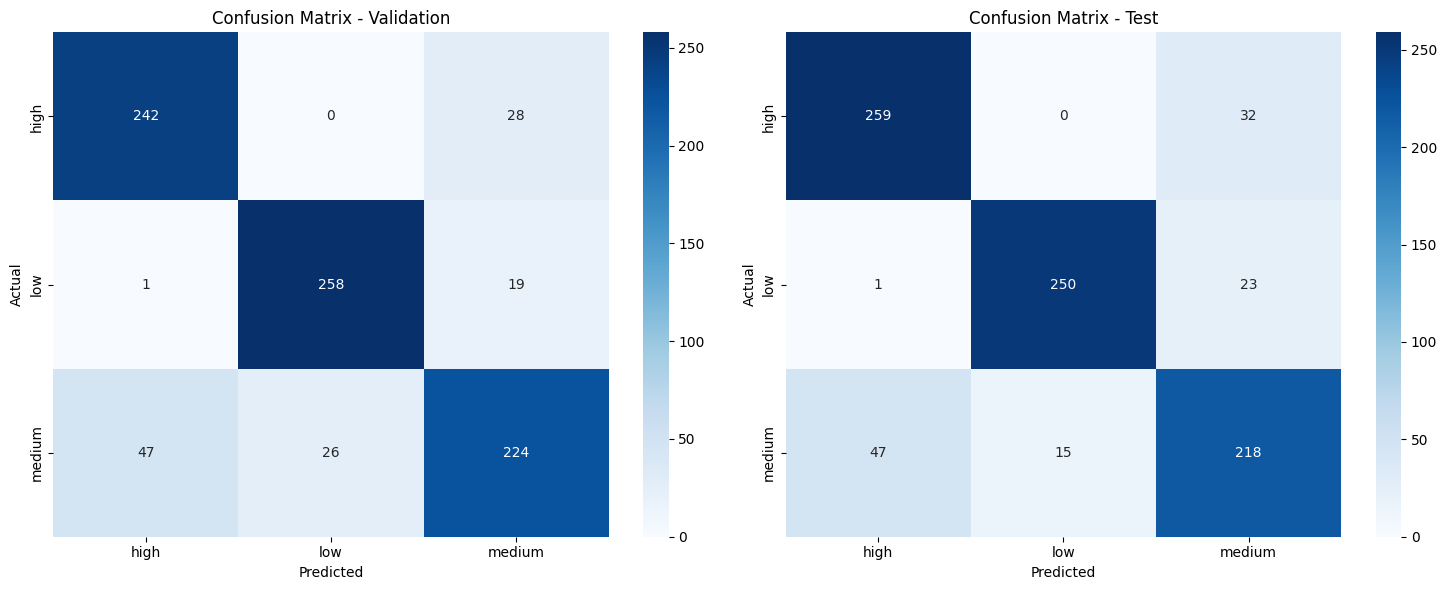

In [27]:
# Step 8: Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, dataset_name, ax=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    classes = sorted(set(y_true))

    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f'Confusion Matrix - {dataset_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    return cm

print("Step 8: Creating confusion matrices...")

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Validation confusion matrix
val_cm = plot_confusion_matrix(y_val, val_predictions, "Validation", axes[0])

# Test confusion matrix
test_cm = plot_confusion_matrix(y_test, test_predictions, "Test", axes[1])

plt.tight_layout()
plt.show()


Step 9: Creating Training Progress Analysis...


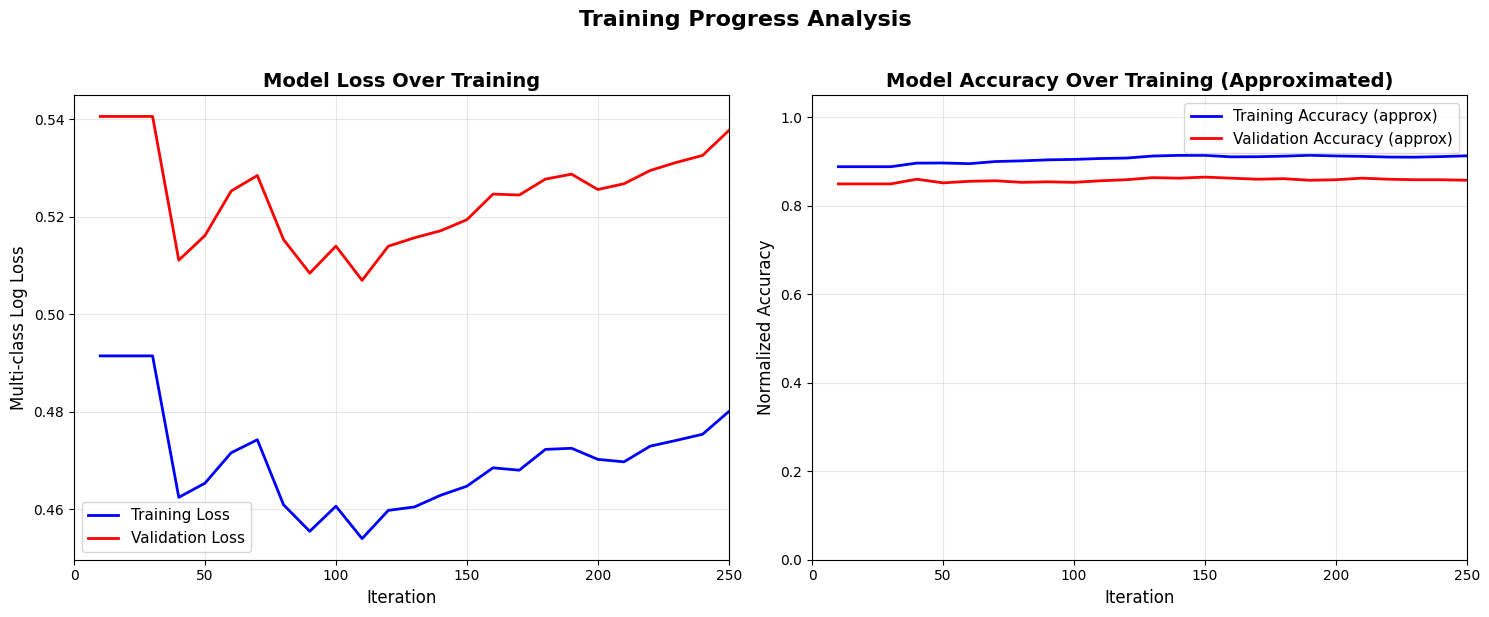

(0.0, 1.0)

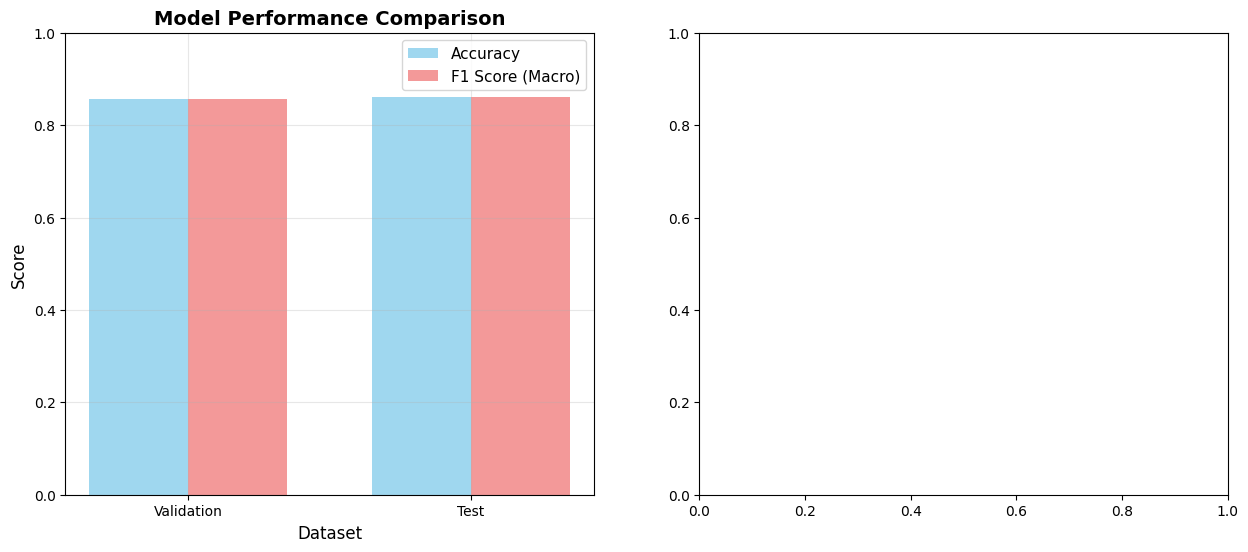

In [28]:

# Step 9: Training Progress Analysis Visualization
print("Step 9: Creating Training Progress Analysis...")

# Create the training progress analysis figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model Loss Over Training
ax1.plot(iterations, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(iterations, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Multi-class Log Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(iterations))

# Plot 2: Model Accuracy Over Training (Approximated)
ax2.plot(iterations, train_accs, 'b-', label='Training Accuracy (approx)', linewidth=2)
ax2.plot(iterations, val_accs, 'r-', label='Validation Accuracy (approx)', linewidth=2)
ax2.set_title('Model Accuracy Over Training (Approximated)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Normalized Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, max(iterations))
ax2.set_ylim(0, 1.05)

# Add main title
fig.suptitle('Training Progress Analysis', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Additional visualization: Model Performance Comparison and Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model Performance Comparison
datasets = ['Validation', 'Test']
accuracies = [val_metrics['accuracy'], test_metrics['accuracy']]
f1_scores = [val_metrics['f1_macro'], test_metrics['f1_macro']]

x = np.arange(len(datasets))
width = 0.35

axes[0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
axes[0].bar(x + width/2, f1_scores, width, label='F1 Score (Macro)', alpha=0.8, color='lightcoral')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dataset', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.0)




In [29]:

# Step 10: Summary Report
print("Step 10: Final Summary Report")
print("=" * 70)
print("RANDOM FOREST CLASSIFICATION MODEL - FINAL REPORT")
print("=" * 70)

print(f"\nModel Configuration:")
print(f"- Number of estimators: {model.n_estimators}")
print(f"- Max depth: {model.max_depth}")
print(f"- Min samples split: {model.min_samples_split}")
print(f"- Min samples leaf: {model.min_samples_leaf}")
print(f"- Training iterations: {max(iterations)}")

print(f"\nDataset Information:")
print(f"- Training samples: {len(X_train)}")
print(f"- Validation samples: {len(X_val)}")
print(f"- Test samples: {len(X_test)}")
print(f"- Number of features: {X_train.shape[1]}")

print(f"\nProduction Label Distribution (Training):")
label_dist = train_df['production_label'].value_counts()
for label, count in label_dist.items():
    percentage = (count / len(train_df)) * 100
    print(f"- {label.capitalize()}: {count} ({percentage:.1f}%)")

print(f"\nQuantile Thresholds:")
print(f"- Low/Medium threshold: {q33_train:.2f} M.Ton")
print(f"- Medium/High threshold: {q67_train:.2f} M.Ton")

print(f"\nFinal Performance Summary:")
print(f"VALIDATION SET:")
print(f"- Accuracy: {val_metrics['accuracy']:.4f}")
print(f"- Macro F1 Score: {val_metrics['f1_macro']:.4f}")
print(f"- Weighted F1 Score: {val_metrics['f1_weighted']:.4f}")

print(f"\nTEST SET:")
print(f"- Accuracy: {test_metrics['accuracy']:.4f}")
print(f"- Macro F1 Score: {test_metrics['f1_macro']:.4f}")
print(f"- Weighted F1 Score: {test_metrics['f1_weighted']:.4f}")

print(f"\nTraining Progress Summary:")
print(f"- Initial Training Loss: {train_losses[0]:.4f}")
print(f"- Final Training Loss: {train_losses[-1]:.4f}")
print(f"- Initial Validation Loss: {val_losses[0]:.4f}")
print(f"- Final Validation Loss: {val_losses[-1]:.4f}")
print(f"- Best Validation Loss: {min(val_losses):.4f}")

print("\n" + "=" * 70)
print("MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("=" * 70)

Step 10: Final Summary Report
RANDOM FOREST CLASSIFICATION MODEL - FINAL REPORT

Model Configuration:
- Number of estimators: 36
- Max depth: 10
- Min samples split: 5
- Min samples leaf: 2
- Training iterations: 250

Dataset Information:
- Training samples: 3942
- Validation samples: 845
- Test samples: 845
- Number of features: 83

Production Label Distribution (Training):
- Medium: 1340 (34.0%)
- Low: 1301 (33.0%)
- High: 1301 (33.0%)

Quantile Thresholds:
- Low/Medium threshold: 1071.56 M.Ton
- Medium/High threshold: 4035.91 M.Ton

Final Performance Summary:
VALIDATION SET:
- Accuracy: 0.8568
- Macro F1 Score: 0.8571
- Weighted F1 Score: 0.8555

TEST SET:
- Accuracy: 0.8604
- Macro F1 Score: 0.8608
- Weighted F1 Score: 0.8604

Training Progress Summary:
- Initial Training Loss: 0.4914
- Final Training Loss: 0.4800
- Initial Validation Loss: 0.5405
- Final Validation Loss: 0.5376
- Best Validation Loss: 0.5069

MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
